# imports

In [1]:
import torch
torch.cuda.set_device(5)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 5
Current default GPU name: NVIDIA A40


In [2]:
import os


def count_txt_files(folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return 0
    
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter and count files that end with .txt
    txt_files_count = sum(1 for file in files if file.endswith('.txt'))
    
    return txt_files_count
def count_png_files(folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return 0
    
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter and count files that end with .txt
    txt_files_count = sum(1 for file in files if file.endswith('.png'))
    
    return txt_files_count


In [3]:
import os
import time

def wait_for_files(directory, target_count=40):
    """
    Continuously checks the directory until it contains at least target_count .txt files.

    Args:
    directory (str): The path to the directory to check.
    target_count (int): The minimum number of .txt files desired in the directory.
    """
    while True:
        count = count_txt_files(directory)
        print(f"Checking... There are currently {count} .txt files.")
        if count >= target_count:
            print(f"Reached target of {target_count} .txt files.")
            time.sleep(500)
            break
        time.sleep(20)  # Wait for 10 seconds before checking again

# # Example usage
# directory_path = 'saved_data/cifar_train500_2syn_i2i/'
# wait_for_files(directory_path)

In [4]:
# all imports

# buffer
from collections import defaultdict
import random
from abc import ABC, abstractmethod
from typing import (
    Any,
    Dict,
    Generic,
    Optional,
    List,
    TYPE_CHECKING,
    Set,
    TypeVar,
)

from avalanche.benchmarks.utils import (
    classification_subset,
    AvalancheDataset,
)
from avalanche.models import FeatureExtractorBackbone
# from ..benchmarks.utils.utils import concat_datasets
from avalanche.benchmarks.utils import concat_datasets
from avalanche.training.storage_policy import ReservoirSamplingBuffer, BalancedExemplarsBuffer, ClassBalancedBuffer

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy, ExemplarsBuffer, ExperienceBalancedBuffer
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from typing import Optional, TYPE_CHECKING

from avalanche.benchmarks.utils import concat_classification_datasets
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin

if TYPE_CHECKING:
    from avalanche.training.templates import SupervisedTemplate, BaseSGDTemplate

# dataset
from avalanche.benchmarks import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader, ReplayDataLoader
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark

from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger, TensorboardLogger

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics

from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training.plugins import ReplayPlugin
from types import SimpleNamespace
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf

In [6]:
# all imports

import torch
import os
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms
import torch.optim.lr_scheduler # ?
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, CenterCrop, RandomHorizontalFlip, Resize
from torchvision.transforms.functional import center_crop
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import pil_to_tensor


In [7]:
# import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform = transform_train = Compose([
    # Resize(224),
    # Resize(384),
    # RandomHorizontalFlip(),
    ToTensor(),
    # Normalize(*stats,inplace=True)
])

# Load the CIFAR-100 training set
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)

name_list = trainset.classes

Files already downloaded and verified


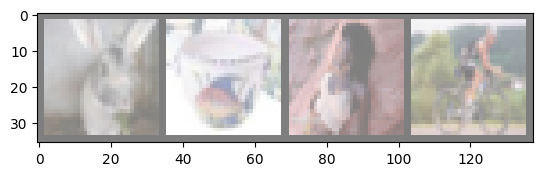

rabbit  bowl woman bicycle


In [8]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if Normalize was used in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))


In [9]:

def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor).convert("RGB")

In [10]:
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision.utils import save_image


def save_cifar100_random_replay(dataset, num_images_per_class, save_dir):
	if not os.path.exists(save_dir):
		os.makedirs(save_dir)
	torch.manual_seed(41)

	saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class

	transform_to_tensor = transforms.ToTensor()

	indices = torch.randperm(len(dataset)).tolist()
	for idx in indices:
		image, label = dataset[idx]

		# Check if image is already a tensor, transform if not
		if not isinstance(image, torch.Tensor):
			image_tensor = transform_to_tensor(image)
		else:
			image_tensor = image  # Use the image directly if it is already a tensor

		# Skip saving if this class already has the desired number of images saved
		if saved_counts[label] >= num_images_per_class:
			continue

		class_name = dataset.classes[label]
		image_path = os.path.join(save_dir, f'{class_name}{saved_counts[label]}.png')
		save_image(image_tensor, image_path)
		saved_counts[label] += 1

		# Check if we have finished saving max_images for all classes
		class_file_path = os.path.join(save_dir, f"class{label}.txt")
		with open(class_file_path, "a") as file:
			file.write(f"{image_path} {label}\n")

		# Check if we have finished saving the specified number of images for all classes
		if all(count >= num_images_per_class for count in saved_counts.values()):
			break
# 		if saved_counts[1] < num_images_per_class:
# 			print('not enough data', saved_counts[1])
	print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")


integer_to_name = {i: name for i, name in enumerate(name_list)}

import os
import torch
from torchvision import transforms
from torchvision.utils import save_image

def save_specific_cifar100(dataset, num_images_per_class, save_dir, real_list):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.manual_seed(41)

    saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class

    transform_to_tensor = transforms.ToTensor()

    indices = torch.randperm(len(dataset)).tolist()
    
    for idx in indices:
        image, label = dataset[idx]
        
        if label in real_list:
            # Check if image is already a tensor, transform if not
            if not isinstance(image, torch.Tensor):
                image_tensor = transform_to_tensor(image)
            else:
                image_tensor = image  # Use the image directly if it is already a tensor

            # Skip saving if this class already has the desired number of images saved
            if saved_counts[label] >= num_images_per_class:
                continue

            class_name = dataset.classes[label]
            image_path = os.path.join(save_dir, f'{class_name}{saved_counts[label]}.png')
            save_image(image_tensor, image_path)
            saved_counts[label] += 1

            # Save path to file
            class_file_path = os.path.join(save_dir, f"class{label}.txt")
            with open(class_file_path, "a") as file:
                file.write(f"{image_path} {label}\n")

            # Check if we have finished saving the specified number of images for all classes
            if all(count >= num_images_per_class for count in saved_counts.values()):
                break

    print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")


def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}
    print(filenames_to_look_for)
    
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over each file in the specified folder
#     files_found = 0
    
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
#             print(f'found file {file}')
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation
#                 print(combined_content)

    joined_string = '_'.join(str(integer) for integer in numbers)


    output_file_path = os.path.join(output_folder, f"{file_initial}combined_{joined_string}.txt")
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)


In [11]:
# def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
#     combined_content = ""
#     filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}
#     print(f"Looking for filenames: {filenames_to_look_for}")
    
#     os.makedirs(output_folder, exist_ok=True)

#     for file in os.listdir(folder):
#         print(f"Checking file: {file}")
#         if file in filenames_to_look_for:
#             print(f"Found and processing file: {file}")
#             with open(os.path.join(folder, file), 'r') as f:
#                 file_content = f.read()
#                 combined_content += file_content + "\n"  # Ensure separation with newline
#                 print(f"Current combined content length: {len(combined_content)}")

#     joined_string = '_'.join(str(integer) for integer in numbers)
#     output_file_path = os.path.join(output_folder, f"{file_initial}combined_{joined_string}.txt")
#     print(f"Writing to output file: {output_file_path}")

#     with open(output_file_path, 'w') as f:
#         f.write(combined_content)


In [12]:
# sythnthesis classes
benchmark = SplitCIFAR100(n_experiences=20,
                          seed = 41,             
                          )

orders = benchmark.classes_order
order_list = [orders[x:x+5] for x in range(0, len(orders), 5)]

order_sample = [order[3:] for order in order_list]
classname_list = []
label_list = []
classname_list_sep = []
for order_l in order_sample:
    label_list.append(order_l)
    cur_classname = [integer_to_name[i] for i in order_l]
    classname_list.append(cur_classname)
classname_list_sep = [item for lists in classname_list for item in lists]
label_list_sep = [item for lists in label_list for item in lists]
print(label_list_sep)

Files already downloaded and verified
Files already downloaded and verified
[5, 20, 83, 19, 62, 33, 74, 53, 4, 32, 40, 41, 64, 21, 49, 68, 65, 46, 72, 31, 8, 1, 18, 86, 85, 95, 25, 82, 66, 37, 78, 52, 3, 99, 28, 90, 17, 77, 79, 58]


In [13]:
real_list = set([i for i in range(100)]) - set(label_list_sep)

In [14]:
testset = torchvision.datasets.CIFAR100(root='data', train=False,
                                         download=True, transform=transform)

Files already downloaded and verified


In [15]:
# save_specific_cifar100(trainset, 500, 'saved_data/cifar_train500_2real', real_list)

In [16]:
output_folder = 'saved_data/real_sythesis_cifar100_llava'
count = count_txt_files(output_folder)
print(f"There are {count} .txt files in the folder.")
count = count_png_files(output_folder)
print(f"There are {count} .png files in the folder.")

There are 100 .txt files in the folder.
There are 50000 .png files in the folder.


In [17]:
# save_cifar100_random_replay(testset, 100, 'saved_data/cifar_test100')

In [18]:
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)

name_list = trainset.classes

integer_to_name = {i: name for i, name in enumerate(name_list)}


Files already downloaded and verified


In [19]:
for id in integer_to_name:
    print(id, integer_to_name[id])
    break

0 apple


In [20]:
import os
import shutil

def filter_class_txt_files(folder_path, output_folder, specific_dict_integer_to_name, folder_path2 = None):
    """
    Filters out images and text files for specified classes and copies them to a new directory.

    Args:
    image_folder (str): Path to the directory containing images.
    txt_folder (str): Path to the directory containing text files.
    output_folder (str): Path to the directory where filtered files should be stored.
    class_list (list): List of class numbers as strings.
    """
    # Ensure output directory exists
    
    class_numbers = list(specific_dict_integer_to_name.keys())
    class_names = list(specific_dict_integer_to_name.values())
        
    
    os.makedirs(output_folder, exist_ok=True)
    if not folder_path2:
        file_list = os.listdir(folder_path)
    else:
        file_list = os.listdir(folder_path) + os.listdir(folder_path2)

    for file in file_list:
        # Check if the file is an image or a text file for the classes in the list
        if (file.endswith('.txt') and int(file.split('class')[1].split('.txt')[0]) in class_numbers):
            # Copy file to output directory
            if file in os.listdir(folder_path):
                shutil.copy(os.path.join(folder_path, file), os.path.join(output_folder, file))
            else:
                shutil.copy(os.path.join(folder_path2, file), os.path.join(output_folder, file))



In [21]:
syn_dict = {class_number: integer_to_name[class_number] for class_number in label_list_sep if class_number in integer_to_name}

In [22]:
print(syn_dict)

{5: 'bed', 20: 'chair', 83: 'sweet_pepper', 19: 'cattle', 62: 'poppy', 33: 'forest', 74: 'shrew', 53: 'orange', 4: 'beaver', 32: 'flatfish', 40: 'lamp', 41: 'lawn_mower', 64: 'possum', 21: 'chimpanzee', 49: 'mountain', 68: 'road', 65: 'rabbit', 46: 'man', 72: 'seal', 31: 'elephant', 8: 'bicycle', 1: 'aquarium_fish', 18: 'caterpillar', 86: 'telephone', 85: 'tank', 95: 'whale', 25: 'couch', 82: 'sunflower', 66: 'raccoon', 37: 'house', 78: 'snake', 52: 'oak_tree', 3: 'bear', 99: 'worm', 28: 'cup', 90: 'train', 17: 'castle', 77: 'snail', 79: 'spider', 58: 'pickup_truck'}


In [23]:
# Example usage
# folder_path = 'saved_data/sd_turbo_500images_llava_firstthreeclasses'
# folder_path2 = 'saved_data/sd_turbo_500images_llava'
# output_folder = 'saved_data/sd_turbo_500images_llava_3syn'

# filter_class_txt_files(folder_path, output_folder, syn_dict, folder_path2)


In [24]:
# count = count_txt_files(output_folder)
# print(f"There are {count} .txt files in the folder.")
# count = count_png_files(output_folder)
# print(f"There are {count} .png files in the folder.")

## dataset concate

## llava prompt multiple 3 real 2 synthesis i2i

In [58]:

import shutil
import os


# combine the real and sythesis data
folder1 = 'saved_data/cifar_train500_3real_fori2i'
folder2 = 'saved_data/cifar_train500_2syn_i2i_step10'
destination_folder = 'saved_data/real_sythesis_cifar100_llava_i2i_3real_2'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

def copy_contents(src, dst):
    for item in os.listdir(src):
        src_path = os.path.join(src, item)
        dst_path = os.path.join(dst, item)

        if os.path.isdir(src_path):
            if not os.path.exists(dst_path):
                os.makedirs(dst_path)
            copy_contents(src_path, dst_path)  # Recursively copy subdirectories
        else:
            shutil.copy2(src_path, dst_path)  # Copy files

# copy_contents(folder1, destination_folder)
# copy_contents(folder2, destination_folder)


train_experience_list = []
for l in order_list:
    combine_files_with_numbers(
                destination_folder,
                'class',
                l,
                destination_folder + '_combined/')
    
    joined_string = '_'.join(str(integer) for integer in l)
    output_folder = destination_folder + '_combined/'
    file_initial = 'class'
    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt' 
    train_experience_list.append(output_file_path)


saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_36_0_54_5_20.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_22_45_13_83_19.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_26_73_16_62_33.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_34_98_24_74_53.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_10_94_51_4_32.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_38_81_50_40_41.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_30_89_69_64_21.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_84_14_88_49_68.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_6_80_57_65_46.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/classcombined_9_91_48_72_31.txt
saved_data/real_sythesis_cifar100_llava_i2i_3real_2_combined/clas

In [59]:

# Specify the folder path here
# folder_path = 'saved_data/real_sythesis_cifar100_baseprompt/'
folder_path = 'saved_data/real_sythesis_cifar100_llava_i2i_3real_2'

# Call the function and print the result
count = count_txt_files(folder_path)
print(f"There are {count} .txt files in the folder.")
count = count_png_files(folder_path)
print(f"There are {count} .png files in the folder.")

There are 100 .txt files in the folder.
There are 50000 .png files in the folder.


In [60]:
import os

def list_first_ten_files(folder_path):
    """Prints the names of the first 10 files in the specified folder."""
    
    # Make sure the folder exists
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return
    
    # List files in the directory
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Print the first 10 files
    for file in files[:10]:
        print(file)

# Example usage:
folder_path = "saved_data/real_sythesis_cifar100_llava_i2i_3real"
list_first_ten_files(folder_path)


table0.png
class84.txt
bee0.png
class6.txt
kangaroo0.png
class38.txt
clock0.png
class22.txt
television0.png
class87.txt


In [61]:
test_experience_list = []
for l in order_list:
    combine_files_with_numbers(
                'saved_data/cifar_test100',
                'class',
                l,
                'saved_data/cifar_test100' + '_combined/')
    
    joined_string = '_'.join(str(integer) for integer in l)
    output_folder = 'saved_data/cifar_test100' + '_combined/'
    file_initial = 'class'
    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt' 
    test_experience_list.append(output_file_path)


saved_data/cifar_test100_combined/classcombined_36_0_54_5_20.txt
saved_data/cifar_test100_combined/classcombined_22_45_13_83_19.txt
saved_data/cifar_test100_combined/classcombined_26_73_16_62_33.txt
saved_data/cifar_test100_combined/classcombined_34_98_24_74_53.txt
saved_data/cifar_test100_combined/classcombined_10_94_51_4_32.txt
saved_data/cifar_test100_combined/classcombined_38_81_50_40_41.txt
saved_data/cifar_test100_combined/classcombined_30_89_69_64_21.txt
saved_data/cifar_test100_combined/classcombined_84_14_88_49_68.txt
saved_data/cifar_test100_combined/classcombined_6_80_57_65_46.txt
saved_data/cifar_test100_combined/classcombined_9_91_48_72_31.txt
saved_data/cifar_test100_combined/classcombined_76_7_47_8_1.txt
saved_data/cifar_test100_combined/classcombined_61_75_63_18_86.txt
saved_data/cifar_test100_combined/classcombined_59_70_43_85_95.txt
saved_data/cifar_test100_combined/classcombined_27_93_35_25_82.txt
saved_data/cifar_test100_combined/classcombined_44_56_67_66_37.txt
sav

## create benchmark

In [62]:
sythesis_cifar_benchmark =  filelist_benchmark(
                                None,
                                train_file_lists = train_experience_list, # train
                                test_file_lists = test_experience_list, # test
                                task_labels = [0]*20,
                                # complete_test_set_only=True,
                                train_transform=transform_train,
                            eval_transform=transform_train
                            )

In [63]:
train_stream = sythesis_cifar_benchmark.train_stream
for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')
    print(f'This contains labels {experience.classes_in_this_experience}')

Task 0 batch 0 -> train
This batch contains 2500 patterns
This contains labels [0, 36, 5, 20, 54]
Task 0 batch 1 -> train
This batch contains 2500 patterns
This contains labels [45, 13, 19, 83, 22]
Task 0 batch 2 -> train
This batch contains 2500 patterns
This contains labels [33, 73, 16, 26, 62]
Task 0 batch 3 -> train
This batch contains 2500 patterns
This contains labels [98, 34, 74, 53, 24]
Task 0 batch 4 -> train
This batch contains 2500 patterns
This contains labels [32, 4, 10, 51, 94]
Task 0 batch 5 -> train
This batch contains 2500 patterns
This contains labels [38, 40, 41, 81, 50]
Task 0 batch 6 -> train
This batch contains 2500 patterns
This contains labels [64, 69, 21, 89, 30]
Task 0 batch 7 -> train
This batch contains 2500 patterns
This contains labels [68, 14, 49, 84, 88]
Task 0 batch 8 -> train
This batch contains 2500 patterns
This contains labels [65, 6, 46, 80, 57]
Task 0 batch 9 -> train
This batch contains 2500 patterns
This contains labels [72, 9, 48, 91, 31]
Task 

# Data transform

In [64]:
# !pip install pytorch_pretrained_vit


import torch
import matplotlib.pyplot as plt
import numpy as np
# ?

from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10

from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark



In [65]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Resize
import os
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform_train = Compose([
    Resize(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(*stats,inplace=True)
])

transform_test = Compose([
    Resize(224),
    ToTensor(),
    Normalize(*stats,inplace=True)
])


# attention, logs

In [66]:
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger
# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('logs/log_real_sythesis_llavaprompt_class_3real_i2i_redoexperiment.txt', 'w'))

# print to stdout
interactive_logger = InteractiveLogger()

In [67]:
# evaluation
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, class_accuracy_metrics

# The evaluation plugin manages the metrics computation.
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=False, epoch_running=False, experience=False, stream=True),
    # forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger])

In [68]:
from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager


In [69]:
RNGManager.set_random_seeds(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

checkpoint_plugin = CheckpointPlugin(
    FileSystemCheckpointStorage(
        directory='./checkpoints/task_cifar',
    ),
    map_location=device
)

# Load checkpoint (if exists in the given storage)
# If it does not exist, strategy will be None and initial_exp will be 0
strategy, initial_exp = checkpoint_plugin.load_checkpoint_if_exists()

cuda


In [70]:
import os
import random

def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}

    # Iterate over each file in the specified folder
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation

    joined_string = '_'.join(str(integer) for integer in numbers)

    os.makedirs(output_folder, exist_ok=True)

    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt'
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

def shuffle_text_file_lines(file_path):
    """
    Shuffles the lines in a text file.

    Parameters:
    - file_path: Path to the text file to shuffle.
    """
    # Read the lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Shuffle the lines
    random.shuffle(lines)

    # Write the shuffled lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# customize replay plugin

In [71]:
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from typing import Optional, TYPE_CHECKING

from avalanche.benchmarks.utils import concat_classification_datasets
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin
from avalanche.training.storage_policy import (
    ExemplarsBuffer,
    ExperienceBalancedBuffer,
)

if TYPE_CHECKING:
    from avalanche.training.templates import SupervisedTemplate

import random
def sample_Avadataset(dataset, percentage= 0.1):
    """random sample in certain percentage, percentage should be float"""
#     random.seed(41)
    torch.manual_seed(41)
    data_len = len(dataset)
#     indices = list(range(data_len))
    indices = torch.randperm(data_len).tolist()
#     random.shuffle(indices)
    sample_num = int(data_len * percentage)
#     sampled_indices = random.sample(indices, sample_num)
#     new_buffer_data = dataset.subset(sampled_indices)
    sampled_indices = indices[:sample_num]  # Select the first 'sample_num' indices
    new_buffer_data = dataset.subset(sampled_indices)

    return new_buffer_data



class CustomReplay(SupervisedPlugin):
    def __init__(
        self,
        mem_size: int = 200,
        batch_size: Optional[int] = None,
        batch_size_mem: Optional[int] = None,
        task_balanced_dataloader: bool = False,
        storage_policy: Optional["ExemplarsBuffer"] = None,
        # The policy that controls how to add new exemplars in memory
                        #
    ):
        super().__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.batch_size_mem = batch_size_mem
        self.task_balanced_dataloader = task_balanced_dataloader

        self.storage_policy = storage_policy
        assert storage_policy.max_size == self.mem_size



    def before_training_exp(self,
                            strategy: "SupervisedTemplate",
                            num_workers: int = 0,
                            shuffle: bool = True,
                            **kwargs):
        """ Here we set the dataloader. create batch with examples from both
        training data and external memory"""
        if len(self.storage_policy.buffer) == 0:
            return

        # replay dataloader samples mini-batches from the memory and current
        # data separately and combines them together.
        print("Override the dataloader.")

        buffer_size = len(self.storage_policy.buffer)
        print("buffer size: " + str(buffer_size))
        num_class = len(self.storage_policy.buffer_datasets)
        print("current class number in replay buffer: " + str(num_class))
        # for item in self.storage_policy.buffer:
        # tempory_buffer = AvalancheDataset([])

        tempory_buffer = []

        for i, dataset in enumerate(self.storage_policy.buffer_datasets):
            sub_data = sample_Avadataset(dataset)
            if i == 0:
                tempory_buffer = sub_data
            else:
                tempory_buffer = tempory_buffer.concat(sub_data)


        # buffer = [sample_Avadataset(dataset) for dataset in self.storage_policy.buffer_datasets]
        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            # self.storage_policy.buffer,
            tempory_buffer,
            num_workers=num_workers,
            batch_size=strategy.train_mb_size,
            shuffle=shuffle)
        # for x, y, t in dl:
        #     print(t.tolist())
        #     print(len(t.tolist()))

    def after_training_exp(self, strategy: "SupervisedTemplate", **kwargs):
        """ We update the buffer after the experience.
            You can use a different callback to update the buffer in a different place
        """
        print("Buffer update.")
        self.storage_policy.update(strategy, **kwargs)
        
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset

class NewParametricBuffer(BalancedExemplarsBuffer):
    """Stores samples for replay using a custom selection strategy and
    grouping."""

    def __init__(
        self,
        max_size: int,
        groupby=None,
        selection_strategy: Optional["ExemplarsSelectionStrategy"] = None,
    ):
        """Init.
        :param max_size: The max capacity of the replay memory.
        :param groupby: Grouping mechanism. One of {None, 'class', 'task',
            'experience'}.
        :param selection_strategy: The strategy used to select exemplars to
            keep in memory when cutting it off.
        """
        super().__init__(max_size)
        assert groupby in {None, "task", "class", "experience"}, (
            "Unknown grouping scheme. Must be one of {None, 'task', "
            "'class', 'experience'}"
        )
        self.groupby = groupby
        ss = selection_strategy or RandomExemplarsSelectionStrategy()
        self.selection_strategy = ss
        self.seen_groups: Set[int] = set()
        self._curr_strategy = None


    def update(self, strategy: "SupervisedTemplate", **kwargs):
        assert strategy.experience is not None
        new_data: AvalancheDataset = strategy.experience.dataset
        new_groups = self._make_groups(strategy, new_data)
        self.seen_groups.update(new_groups.keys())

        # associate lengths to classes
        lens = self.get_group_lengths(len(self.seen_groups))
        group_to_len = {}
        for group_id, ll in zip(self.seen_groups, lens):
            group_to_len[group_id] = ll

        # update buffers with new data
        for group_id, new_data_g in new_groups.items():
            ll = group_to_len[group_id]
            if group_id in self.buffer_groups:
                old_buffer_g = self.buffer_groups[group_id]
                old_buffer_g.update_from_dataset(strategy, new_data_g)
                old_buffer_g.resize(strategy, ll)
            else:
                new_buffer = _ParametricSingleBuffer(ll, self.selection_strategy)
                new_buffer.update_from_dataset(strategy, new_data_g)
                self.buffer_groups[group_id] = new_buffer

        # resize buffers
        for group_id, class_buf in self.buffer_groups.items():
            self.buffer_groups[group_id].resize(strategy, group_to_len[group_id])

    def _make_groups(
        self, strategy, data: AvalancheDataset
    ) -> Dict[int, AvalancheDataset]:
        """Split the data by group according to `self.groupby`."""
        # if self.groupby is None:
        #     return {0: data}
        # elif self.groupby == "task":
        #     return self._split_by_task(data)
        # elif self.groupby == "experience":
        #     return self._split_by_experience(strategy, data)
        # elif self.groupby == "class":
        return self._split_by_class(data)
        # else:
        #     assert False, "Invalid groupby key. Should never get here."

    def _split_by_class(self, data: AvalancheDataset) -> Dict[int, AvalancheDataset]:
        # Get sample idxs per class
        cl_idxs: Dict[int, List[int]] = defaultdict(list)
        targets = getattr(data, "targets")
        for idx, target in enumerate(targets):
            target = int(target)
            cl_idxs[target].append(idx)

        # Make AvalancheSubset per class
        new_groups: Dict[int, AvalancheDataset] = {}
        for c, c_idxs in cl_idxs.items():
            new_groups[c] = classification_subset(data, indices=c_idxs)
        return new_groups

    # def _split_by_experience(
    #     self, strategy, data: AvalancheDataset
    # ) -> Dict[int, AvalancheDataset]:
    #     exp_id = strategy.clock.train_exp_counter + 1
    #     return {exp_id: data}

    # def _split_by_task(self, data: AvalancheDataset) -> Dict[int, AvalancheDataset]:
    #     new_groups = {}
    #     task_set = getattr(data, "task_set")
    #     for task_id in task_set:
    #         new_groups[task_id] = task_set[task_id]
    #     return new_groups



class _ParametricSingleBuffer(ExemplarsBuffer):
    """A buffer that stores samples for replay using a custom selection
    strategy.

    This is a private class. Use `ParametricBalancedBuffer` with
    `groupby=None` to get the same behavior.
    """

    def __init__(
        self,
        max_size: int,
        selection_strategy: Optional["ExemplarsSelectionStrategy"] = None,
    ):
        """
        :param max_size: The max capacity of the replay memory.
        :param selection_strategy: The strategy used to select exemplars to
                                   keep in memory when cutting it off.
        """
        super().__init__(max_size)
        ss = selection_strategy or RandomExemplarsSelectionStrategy()
        self.selection_strategy = ss
        self._curr_strategy = None

    def update(self, strategy: "SupervisedTemplate", **kwargs):
        assert strategy.experience is not None
        new_data = strategy.experience.dataset
        self.update_from_dataset(strategy, new_data)

    def update_from_dataset(self, strategy, new_data):
        # print(new_data[1])
        data_len = len(new_data)
        indices = list(range(data_len))
        random.shuffle(indices)
        sample_num = int(data_len * 0.2)
        sampled_indices = random.sample(indices, sample_num)
        # new_buffer_data = new_data[:sample_num]
        # new_buffer_data = Subset(new_data, sampled_indices)
        new_buffer_data = new_data.subset(sampled_indices)

        self.buffer = self.buffer.concat(new_buffer_data)
        self.resize(strategy, self.max_size)

    def resize(self, strategy, new_size: int):
        self.max_size = new_size
        idxs = self.selection_strategy.make_sorted_indices(
            strategy=strategy, data=self.buffer
        )
        self.buffer = self.buffer.subset(idxs[: self.max_size])


In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image_with_matplotlib(image_path):
    """
    Display an image using matplotlib.

    Args:
    image_path (str): The path to the image file.
    """
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# # Example usage
# image_path = 'saved_data/cifar_train500/cloud10.png'
# display_image_with_matplotlib(image_path)


# experiment 20 tasks

In [73]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [74]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)

In [75]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.plugins import ReplayPlugin

from types import SimpleNamespace

In [76]:
# benchmark = SplitCIFAR100(n_experiences=20,
#                           train_transform=transform_train,
#                           eval_transform = transform_test,
#                           seed = 41
#                           )

benchmark =  filelist_benchmark(
                                None,
                                train_file_lists = train_experience_list, # train
                                test_file_lists = test_experience_list, # test
                                task_labels = [0]*20,
                                # complete_test_set_only=True,
                                train_transform=transform_train,
                            eval_transform=transform_train
                            )

In [77]:
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
storage_p = ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
    # selection_strategy=RandomExemplarsSelectionStrategy()

)


print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
for i in range(5):
    strategy_state = SimpleNamespace(experience=benchmark.train_stream[i])
    # print(len(benchmark.train_stream[i]))
    storage_p.update(strategy_state)
    print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
    # print(f"class targets: {storage_p.buffer.targets}\n")

Max buffer size: 60000, current size: 0
Max buffer size: 60000, current size: 2500
Max buffer size: 60000, current size: 5000
Max buffer size: 60000, current size: 7500
Max buffer size: 60000, current size: 10000
Max buffer size: 60000, current size: 12500


In [78]:
storage_p = ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
    # selection_strategy=RandomExemplarsSelectionStrategy()

)


In [79]:
cl_strategy = Naive(
    resnet_model, torch.optim.SGD(resnet_model.parameters(), lr=0.01, momentum = 0.9),
    CrossEntropyLoss(), train_mb_size=32, train_epochs=50, eval_mb_size=16,
    # eval_every=500,
    device=device,
    evaluator=eval_plugin,
    plugins=[CustomReplay(mem_size=60000, storage_policy = storage_p)]
    )
# mem_size: int = 200,
        # batch_size: Optional[int] = None,
        # batch_size_mem: Optional[int] = None,
        # task_balanced_dataloader: bool = False,
        # storage_policy: Optional["ExemplarsBuffer"] = None,

## llava 50 prompts for 500 images 3 real 2 synthesis i2i

In [80]:
# Training
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:32<00:00,  2.44it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3246
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7004
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.86it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4718
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8608
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  3.98it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1737
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9436
100%|████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:36<00:00,  2.15it/s]
Epoch 31 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0740
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9800
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.21it/s]
Epoch 32 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0182
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9952
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.67it/s]
Epoch 33 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0184
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9932
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.86it/s]
Epoch 34 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0116
	Top1_Acc_

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/71 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/72 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/73 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.85it/s]
Epoch 20 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1961
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9429
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.90it/s]
Epoch 21 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2973
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9175
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.90it/s]
Epoch 22 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2081
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9378
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.59it/s]
Epoch 23 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2992
	Top1_Acc_

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/19 = 0.2600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.6700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.9100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/30 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/31 = 0.0000
	Top1_ClassAcc_Stream/eval_

	Loss_Epoch/train_phase/train_stream/Task000 = 0.3710
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8877
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:31<00:00,  2.50it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2426
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9233
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.58it/s]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2888
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9113
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.65it/s]
Epoch 11 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2987
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9067
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:31<00:00,  2.48it/s]
Epoch 40 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0073
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9987
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.62it/s]
Epoch 41 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0061
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9987
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.61it/s]
Epoch 42 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0430
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9877
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.24it/s]
Epoch 43 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0238
	Top1_Acc_

	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 27.0034
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0000
-- Starting eval on experience 15 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.81it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 26.2918
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp015 = 0.0000
-- Starting eval on experience 16 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.86it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 26.9067
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.0000
-- Starting eval on experience 17 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.0000
Start of experience:  3
Current Classes:  [98, 34, 74, 53, 24]
-- >> Start of training phase << --
Override the dataloader.
buffer size: 7500
current class number in replay buffer: 15
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.40it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.9105
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5348
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:33<00:00,  2.39it/s]
Epoch 1 ended.
	Loss_Epoch/trai

-- Starting eval on experience 7 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.25it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 26.9520
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.0000
-- Starting eval on experience 8 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.70it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 26.9084
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.0000
-- Starting eval on experience 9 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/54 = 0.7200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/55 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/56 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/57 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/59 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:36<00:00,  2.17it/s]
Epoch 49 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0068
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9983
Buffer update.
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.84it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 5.8156
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5580
-- Starting eval on experience 1 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.67it/s]
> Eval on experience 1 (Task 0)

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/12 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/13 = 0.7400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/14 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/15 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/16 = 0.4400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/17 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/18 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/19 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.6100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.5900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.8900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:41<00:00,  1.90it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1347
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9560
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:36<00:00,  2.18it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1991
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9352
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:34<00:00,  2.32it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0952
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9685
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:36<00:00,  2.17it/s]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0636
	Top1_Acc_Epo

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.83it/s]
> Eval on experience 13 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 26.8641
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 = 0.0000
-- Starting eval on experience 14 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.78it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 25.7144
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0000
-- Starting eval on experience 15 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.09it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 26.2914
	Top1

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/86 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/87 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/88 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/89 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/9 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/90 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/91 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/92 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/93 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.9400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.5500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.0000
Start of experience:  6
Cu

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0199
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9928
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:41<00:00,  1.92it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0166
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9962
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.67it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0146
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9952
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.65it/s]
Epoch 30 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0067
	Top1_Acc_

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/45 = 0.3900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/46 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/47 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/48 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/49 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/5 = 0.1300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/50 = 0.4400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/51 = 0.6300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/52 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/53 = 0.2700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/54 = 0.7800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/55 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/56 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/57 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9969
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.71it/s]
Epoch 16 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0508
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9868
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0184
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9955
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0355
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9906
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:50<00:00,  1.55it/s]
Epoch 19 ended.
	Loss_

	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 27.7376
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 17.7997
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1755
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.9100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/10 = 0.3800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/11 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/12 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/13 = 0.6300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/14 = 0.8200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/15 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/16 = 0.5800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/17 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/18 = 0.0000
	Top1_ClassAcc_Stream/eval_

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:01<00:00,  1.28it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1013
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9720
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:50<00:00,  1.58it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0761
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9807
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0412
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9902
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:02<00:00,  1.26it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0559
	Top1_Acc_Epoc

	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 24.7523
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.0000
-- Starting eval on experience 10 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.90it/s]
> Eval on experience 10 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp010 = 23.6397
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.0000
-- Starting eval on experience 11 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.78it/s]
> Eval on experience 11 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp011 = 26.1711
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp011 = 0.0000
-- Starting eval on experience 12 (Task 0) from test stream --


	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.1100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.2100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.8800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/71 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/72 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/73 = 0.6600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/74 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/75 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/76 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:05<00:00,  1.21it/s]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0030
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9996
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:06<00:00,  1.19it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0018
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.25it/s]
Epoch 47 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0031
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9996
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:12<00:00,  2.57it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 21.5729
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.0000
-- Starting eval on experience 17 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.43it/s]
> Eval on experience 17 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp017 = 21.7036
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp017 = 0.0000
-- Starting eval on experience 18 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.83it/s]
> Eval on ex

Start of experience:  10
Current Classes:  [1, 7, 8, 76, 47]
-- >> Start of training phase << --
Override the dataloader.
buffer size: 25000
current class number in replay buffer: 50
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:01<00:00,  1.54s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0511
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6790
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:47<00:00,  1.36s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3463
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8950
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:58<00:00,  1.51s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:23<00:00,  3.35it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0021
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  2.96it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0017
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0019
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

-- Starting eval on experience 3 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.20it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 5.2583
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.3700
-- Starting eval on experience 4 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.58it/s]
> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 6.0480
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.4300
-- Starting eval on experience 5 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.5000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/30 = 0.5600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/31 = 0.1000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/32 = 0.1000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/33 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/34 = 0.5300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/35 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/36 = 0.7200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/37 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/38 = 0.5600
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:17<00:00,  4.91it/s]
Epoch 36 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0013
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:16<00:00,  5.13it/s]
Epoch 37 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0012
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:17<00:00,  4.92it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0014
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.6600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.9100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.1100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.8600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.2200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.7200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.5600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/71 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/72 = 0.0400
	Top1_ClassAcc_Stream/eval_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:19<00:00,  4.74it/s]
Epoch 44 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0017
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9996
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:14<00:00,  6.40it/s]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0016
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9998
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:17<00:00,  5.45it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0010
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.9400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.2100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.6400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.0000
Start of experience:  13
Current Classes:  [35, 82, 25, 27, 93]
-- >> Start of training phase << --
Override the dataloader.
buffer size: 32500
current class number in replay buffer: 65
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:20<00:00,  5.09it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.9084
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6776
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0025
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:18<00:00,  5.40it/s]
Epoch 26 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0031
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9998
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:19<00:00,  5.36it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0035
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9995
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:18<00:00,  5.47it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0022
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0

-- Starting eval on experience 2 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.37it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 5.5311
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.3080
-- Starting eval on experience 3 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.10it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 5.9249
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.3420
-- Starting eval on experience 4 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.3500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.6800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.7500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.2900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.4200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.9100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/30 = 0.5700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/31 = 0.1300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/32 = 0.1000
	Top1_ClassAcc_Stream/eval_

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9945
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:17<00:00,  6.31it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0248
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9963
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:16<00:00,  6.64it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0196
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9985
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:16<00:00,  6.57it/s]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0167
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9968
100%|█████████████████████████████████████████████

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.3520
-- Starting eval on experience 9 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.99it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 4.6522
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.4740
-- Starting eval on experience 10 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.53it/s]
> Eval on experience 10 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp010 = 3.6509
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.4760
-- Starting eval on experience 11 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/59 = 0.6400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.6300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.7200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.1000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.5500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.1700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.8100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.3400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.7100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.5100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.7500
	Top1_ClassAcc_Stream/eval_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:18<00:00,  6.24it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0204
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9965
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:17<00:00,  6.84it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0104
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9989
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:19<00:00,  6.09it/s]
Epoch 19 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0081
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9994
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.64it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 3.7960
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp015 = 0.5140
-- Starting eval on experience 16 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.36it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 18.4396
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.0000
-- Starting eval on experience 17 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.13it/s]
> Eval on exp

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.9100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.1800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.0000
Start of experience:  16
Current Classes:  [97, 99, 3, 39, 55]
-- >> Start of training phase << --
Override the dataloader.
buffer size: 40000
current class number in replay buffer: 80
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:29<00:00,  4.26it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7830
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6752
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0021
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:20<00:00,  6.17it/s]
Epoch 26 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0024
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:22<00:00,  5.52it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0022
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:21<00:00,  5.73it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0019
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1

-- Starting eval on experience 2 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.02it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 5.6103
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.3440
-- Starting eval on experience 3 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.96it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 5.3780
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.3680
-- Starting eval on experience 4 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.4500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.3000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.6600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.7700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.5300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.2200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/30 = 0.5200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/31 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/32 = 0.0600
	Top1_ClassAcc_Stream/eval_

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9942
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:19<00:00,  6.69it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0214
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9957
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:20<00:00,  6.54it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0167
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9976
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:19<00:00,  6.73it/s]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0131
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9984
100%|█████████████████████████████████████████████

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.3620
-- Starting eval on experience 9 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.70it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 4.4209
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.5080
-- Starting eval on experience 10 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.75it/s]
> Eval on experience 10 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp010 = 3.5441
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.4900
-- Starting eval on experience 11 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/59 = 0.7300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.6400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.5000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.6200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.6000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.4200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.2100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.7400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.5600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.7600
	Top1_ClassAcc_Stream/eval_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:21<00:00,  6.43it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0050
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9997
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:23<00:00,  5.89it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0039
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:24<00:00,  5.80it/s]
Epoch 19 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0029
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.25it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 6.0083
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp015 = 0.3200
-- Starting eval on experience 16 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.70it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 4.5833
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.3660
-- Starting eval on experience 17 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.32it/s]
> Eval on expe

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.8300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.5400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.4300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.2400
Start of experience:  19
Current Classes:  [96, 42, 12, 79, 58]
-- >> Start of training phase << --
Override the dataloader.
buffer size: 47500
current class number in replay buffer: 95
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:29<00:00,  4.99it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4839
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7263
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0024
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:26<00:00,  5.70it/s]
Epoch 26 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0023
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:25<00:00,  5.83it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0026
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9997
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:27<00:00,  5.41it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0019
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1

-- Starting eval on experience 2 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.59it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 5.7422
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.3540
-- Starting eval on experience 3 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.69it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 5.1196
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.3780
-- Starting eval on experience 4 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.5000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.4000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.6800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.7300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.7900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.5500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.3300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.3100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.5700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/30 = 0.6800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/31 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/32 = 0.0200
	Top1_ClassAcc_Stream/eval_